In hochdimensionalen Räumen gibt es oft Unterräume, die nur Objekte einer bestimmten Klasse enthalten. 
Wie kann man diese Räume finden?


## Finding entity classes in embeddings

In this notebook we're going to use embeddings to find entity classes and how they correlate with other things

In [ ]:
!python3 -m pip install geopandas==0.5.1

In [5]:
from sklearn import svm
from keras.utils import get_file
import os
import gensim
import numpy as np
import random
import requests
import geopandas as gpd
from IPython.core.pylabtools import figsize
import csv

In [6]:
%matplotlib inline
figsize(12, 8)

as before, let's load up the model

In [7]:
MODEL = 'GoogleNews-vectors-negative300.bin'
#path = get_file(MODEL + '.gz', 'https://s3.amazonaws.com/dl4j-distribution/%s.gz' % MODEL)
unzipped = os.path.join('generated', MODEL)
#if not os.path.isfile(unzipped):
#    with open(unzipped, 'wb') as fout:
#        zcat = subprocess.Popen(['zcat'],
#                          stdin=open(path),
#                          stdout=fout
#                         )
#        zcat.wait()

Most similar to a bunch of countries are some other countries!

In [8]:
model = gensim.models.KeyedVectors.load_word2vec_format(unzipped, binary=True)
model.most_similar(positive=['Germany'])

[('Austria', 0.7461062669754028),
 ('German', 0.7178750038146973),
 ('Germans', 0.6628648042678833),
 ('Switzerland', 0.6506868004798889),
 ('Hungary', 0.6504982709884644),
 ('Germnay', 0.649348258972168),
 ('Netherlands', 0.6437495946884155),
 ('Cologne', 0.6430779695510864),
 ('symbol_RSTI', 0.6389946937561035),
 ('Annita_Kirsten', 0.634294867515564)]

We can see that not only countries are listed. We now want to train a classifier, that can seperate between countries and no-country

In [10]:
model.most_similar(positive=['Annita_Kirsten'])

[('Braustolz_GmbH', 0.7545095682144165),
 ('DIARY_Economic_Indicators', 0.7334568500518799),
 ('##-##_#####_Burscheid', 0.7307887673377991),
 ('WKN_A#N#Y#_Symbol', 0.7260339260101318),
 ('Hoevelaken', 0.7067489624023438),
 ('BMW_###si_1min_##.###secs', 0.7050351500511169),
 ('Primera_EUROPE', 0.699741005897522),
 ('symbol_RSTI', 0.6925466656684875),
 ('Severin_Freund', 0.6898956298828125),
 ('However_Joern_Lauterjung', 0.6885738968849182)]

No we'll create a training set with countries and non countries and get a support vector machine to learn the difference.

In [11]:
countries = list(csv.DictReader(open('data/countries.csv')))
countries[:10], len(countries)

([OrderedDict([('name', 'Canada'), ('cc', 'ca'), ('cc3', 'can')]),
  OrderedDict([('name', 'Turkmenistan'), ('cc', 'tm'), ('cc3', 'tkm')]),
  OrderedDict([('name', 'Ethiopia'), ('cc', 'et'), ('cc3', 'eth')]),
  OrderedDict([('name', 'Swaziland'), ('cc', 'sz'), ('cc3', 'swz')]),
  OrderedDict([('name', 'Czech_Republic'), ('cc', 'cz'), ('cc3', 'cze')]),
  OrderedDict([('name', 'Cameroon'), ('cc', 'cm'), ('cc3', 'cmr')]),
  OrderedDict([('name', 'UAE'), ('cc', 'ae'), ('cc3', 'are')]),
  OrderedDict([('name', 'Liberia'), ('cc', 'lr'), ('cc3', 'lbr')]),
  OrderedDict([('name', 'Netherlands'), ('cc', 'nl'), ('cc3', 'nld')]),
  OrderedDict([('name', 'East_Timor'), ('cc', 'tl'), ('cc3', 'tls')])],
 184)

In [13]:
positive = [x['name'] for x in random.sample(countries, 40)]
negative = random.sample(model.vocab.keys(), 5000)
negative[:5], positive[:5]

(['groan_Go_Daddy',
  'General_Claudio_Bisogniero',
  'By_Yang_Lifei',
  'Year_Mineshaft',
  'Specialty_Underwriters_Alliance'],
 ['Somalia', 'Bhutan', 'Vietnam', 'Colombia', 'Czech_Republic'])

In [16]:
len(model["Somalia"]) # vector dimension of each word

300

In [17]:
# label the data, 1=positive / 0=negatives
labelled = [(p, 1) for p in positive] + [(n, 0) for n in negative]
# shuffle the data
random.shuffle(labelled)
X = np.asarray([model[w] for w, l in labelled])
y = np.asarray([l for w, l in labelled])
X.shape, y.shape

((5040, 300), (5040,))

In [18]:
TRAINING_FRACTION = 0.3
cut_off = int(TRAINING_FRACTION * len(labelled))
clf = svm.SVC(kernel='linear')
clf.fit(X[:cut_off], y[:cut_off]) 

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

We did alright, 99.9% precision:

In [19]:
res = clf.predict(X[cut_off:])

missed = [country for (pred, truth, country) in 
 zip(res, y[cut_off:], labelled[cut_off:]) if pred != truth]

100 - 100 * float(len(missed)) / len(res), missed

(99.94331065759637, [('England', 1), ('Papua', 1)])

In [20]:
all_predictions = clf.predict(model.syn0)

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:1: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.vectors instead).
  if __name__ == '__main__':


In [21]:
res = []
for word, pred in zip(model.index2word, all_predictions):
    if pred:
        res.append(word)
        if len(res) == 150:
            break
random.sample(res, 10)

['Kuwait',
 'Panama',
 'Malawi',
 'Luxembourg',
 'Taiwan',
 'Australia',
 'Armenia',
 'Costa_Rica',
 'Dubai',
 'Oman']

# Semantische Abstände innerhalb einer Klasse berechnen
Wie findet man die relevantesten Elemente innerhalb einer Klasse zu einem bestimmten Kriterium?

In [25]:
country_to_idx = {country['name']: idx for idx, country in enumerate(countries)}
country_vecs = np.asarray([model[c['name']] for c in countries])
country_vecs.shape, country_vecs

((184, 300), array([[-0.13671875, -0.15429688,  0.26953125, ...,  0.02099609,
          0.28515625, -0.2578125 ],
        [-0.21875   ,  0.11035156,  0.02746582, ...,  0.265625  ,
          0.23339844,  0.34765625],
        [-0.02148438,  0.28125   ,  0.09619141, ..., -0.05517578,
          0.11523438,  0.21582031],
        ...,
        [-0.02172852, -0.00756836, -0.12304688, ..., -0.14355469,
         -0.1875    , -0.09179688],
        [-0.04272461, -0.09619141,  0.25585938, ..., -0.07226562,
          0.21875   ,  0.03076172],
        [-0.04858398,  0.19335938,  0.09130859, ...,  0.23144531,
          0.36328125,  0.2421875 ]], dtype=float32))

Quick sanity check to see what is similar to Canada:

In [23]:
dists = np.dot(country_vecs, country_vecs[country_to_idx['Canada']])
for idx in reversed(np.argsort(dists)[-10:]):
    print(countries[idx]['name'], dists[idx])

Canada 7.544024
New_Zealand 3.9619699
Finland 3.9392407
Puerto_Rico 3.838145
Jamaica 3.8102932
Sweden 3.8042789
Slovakia 3.703874
Australia 3.671101
Bahamas 3.6240416
United_States 3.5374339


Ranking countries for a specific term:

In [26]:
def rank_countries(term, topn=10, field='name'):
    if not term in model:
        return []
    vec = model[term]
    dists = np.dot(country_vecs, vec)
    return [(countries[idx][field], float(dists[idx])) 
            for idx in reversed(np.argsort(dists)[-topn:])]

In [34]:
rank_countries('cricket')

[('Sri_Lanka', 5.92276668548584),
 ('Zimbabwe', 5.336524963378906),
 ('Bangladesh', 5.192489147186279),
 ('Pakistan', 4.948408126831055),
 ('Guyana', 3.9162838459014893),
 ('Barbados', 3.757995128631592),
 ('India', 3.7504398822784424),
 ('South_Africa', 3.6561501026153564),
 ('New_Zealand', 3.642028570175171),
 ('Fiji', 3.608567714691162)]

Now let's visualize this on a world map:

In [35]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.head()

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,920938,Oceania,Fiji,FJI,8374.0,"(POLYGON ((180 -16.06713266364245, 180 -16.555..."
1,53950935,Africa,Tanzania,TZA,150600.0,POLYGON ((33.90371119710453 -0.950000000000000...
2,603253,Africa,W. Sahara,ESH,906.5,POLYGON ((-8.665589565454809 27.65642588959236...
3,35623680,North America,Canada,CAN,1674000.0,"(POLYGON ((-122.84 49.00000000000011, -122.974..."
4,326625791,North America,United States of America,USA,18560000.0,"(POLYGON ((-122.84 49.00000000000011, -120 49...."


We can now plot some maps!

You are using pip version 10.0.1, however version 19.2.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


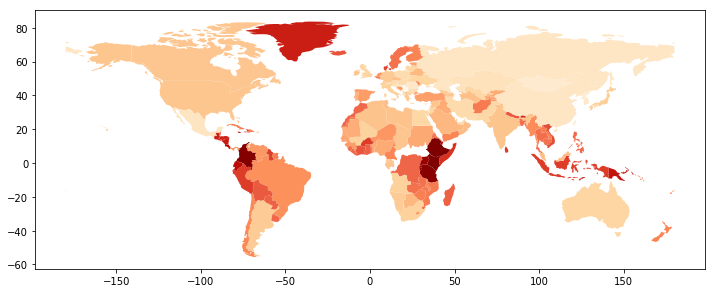

In [37]:
!python3 -m pip install descartes
def map_term(term):
    d = {k.upper(): v for k, v in rank_countries(term, topn=0, field='cc3')}
    world[term] = world['iso_a3'].map(d)
    world[term] /= world[term].max()
    world.dropna().plot(term, cmap='OrRd')

map_term('coffee')

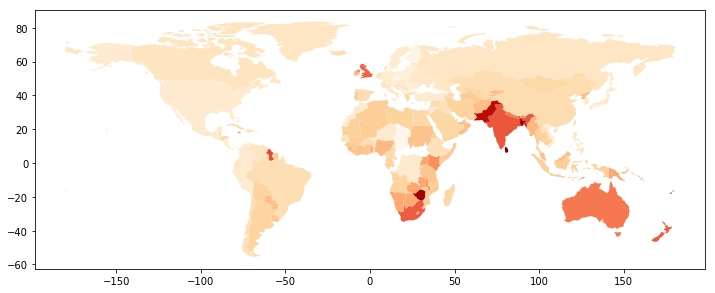

In [38]:
map_term('cricket')

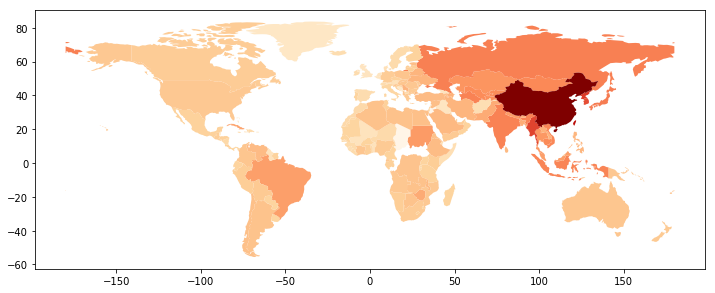

In [39]:
map_term('China')

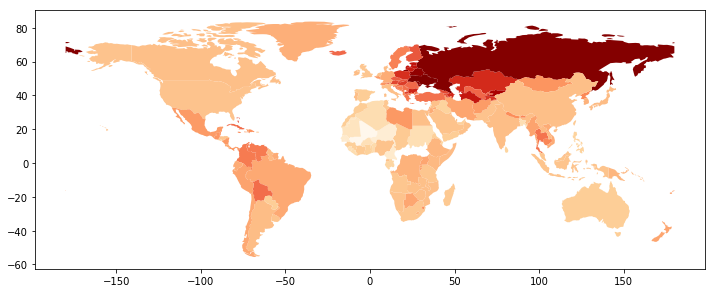

In [40]:
map_term('vodka')

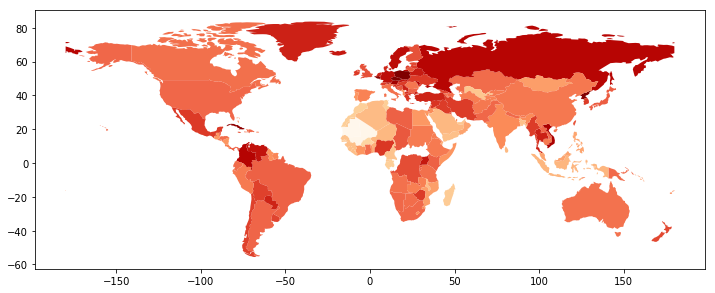

In [44]:
map_term('beer')